In [30]:
# Cell 1 - Imports and Setup
"""
Core imports and configuration setup
Organized by functionality
"""
# Standard library imports
import os
from datetime import datetime
from pathlib import Path
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import warnings
from IPython.display import HTML
import time

# Audio processing imports
import librosa
import audioread
from mutagen.flac import FLAC
from mutagen.mp3 import MP3
from mutagen.wave import WAVE
from mutagen.aac import AAC
from mutagen.aiff import AIFF

# Data handling imports
import numpy as np
import pandas as pd
from scipy import stats

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Constants and configurations
SUPPORTED_FORMATS = {
    '.flac': ['audio/flac', FLAC],
    '.mp3': ['audio/mp3', MP3],
    '.wav': ['audio/wav', WAVE],
    '.aac': ['audio/aac', AAC],
    '.aiff': ['audio/aiff', AIFF],
    '.wma': ['audio/wma', None]  # Requires additional handling
}

In [29]:
# Cell 2 - User Interface Functions
"""
Functions for handling user input and file selection with improved directory handling
"""
def get_default_genre(artist, album):
    """Get default genre based on artist/album"""
    artist_genres = {
        'Wilco': 'Alternative Rock',
        'Kansas': 'Progressive Rock',
        'Spacehog': 'Alternative Rock',
    }
    
    for known_artist, genre in artist_genres.items():
        if known_artist.lower() in artist.lower():
            return genre
    
    return 'Unknown Genre'

def extract_metadata(audio_meta):
    """Extract metadata from audio file with genre handling"""
    try:
        metadata = {
            'Title': audio_meta.tags.get('TITLE', [''])[0] if hasattr(audio_meta, 'tags') else '',
            'Album': audio_meta.tags.get('ALBUM', [''])[0] if hasattr(audio_meta, 'tags') else '',
            'Artist': audio_meta.tags.get('ARTIST', [''])[0] if hasattr(audio_meta, 'tags') else '',
            'Genre': audio_meta.tags.get('GENRE', [''])[0] if hasattr(audio_meta, 'tags') else ''
        }
        
        if not metadata['Genre']:
            metadata['Genre'] = get_default_genre(metadata['Artist'], metadata['Album'])
        
        return metadata
    except:
        return get_basic_metadata(None)

def get_basic_metadata(file_path):
    """Get basic metadata with default genre"""
    if file_path:
        filename = os.path.basename(file_path)
        filename_no_ext = os.path.splitext(filename)[0]
        
        path_parts = Path(file_path).parts
        artist = path_parts[-3] if len(path_parts) > 2 else 'Unknown Artist'
        album = path_parts[-2] if len(path_parts) > 1 else 'Unknown Album'
    else:
        filename_no_ext = 'Unknown Title'
        artist = 'Unknown Artist'
        album = 'Unknown Album'
    
    return {
        'Title': filename_no_ext,
        'Album': album,
        'Artist': artist,
        'Genre': get_default_genre(artist, album)
    }

def analyze_audio_file(file_path, file_number):
    """Analyze single audio file with consistent genre handling"""
    try:
        # Load audio with caching
        audio_data, sample_rate = librosa.load(file_path, sr=None)
        
        # Get metadata based on file type
        ext = os.path.splitext(file_path)[1].lower()
        metadata_reader = SUPPORTED_FORMATS[ext][1]
        if metadata_reader:
            audio_meta = metadata_reader(file_path)
            metadata = extract_metadata(audio_meta)
        else:
            metadata = get_basic_metadata(file_path)
        
        # Extract features
        features = extract_features(audio_data, sample_rate)
        
        # Combine metadata and features
        analysis = {
            'File_Number': file_number,
            'Filename': os.path.basename(file_path),
            'Analysis_Date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            **metadata,
            **features
        }
        
        return analysis
        
    except Exception as e:
        print(f"\nError analyzing {os.path.basename(file_path)}: {str(e)}")
        return None



def get_user_preferences():
    """Get user preferences with improved quick input flow"""
    print("\n=== Welcome to Spectralify, your all-in-one music analysis tool! ===")
    print("\n=== Audio Analysis Configuration ===")
    print("\nWould you like to:")
    print("1. Use quick input format")
    print("2. Go through detailed menu")
    
    choice = input("\nEnter choice (1-2): ").strip()
    
    if choice == '1':
        # Show basic examples and format
        print("\nQuick Input Examples:")
        print("1. Analyze single file:")
        print("   1,C:\\Music\\song.flac")
        print("\n2. Analyze album directory with visualizations:")
        print("   2,C:\\Music\\Album,,auto,yes")
        print("\n3. Analyze artist directory with custom name:")
        print("   3,C:\\Music\\Artist,C:\\Analysis,artist_analysis,yes")
        print("\n4. Full library scan:")
        print("   4,C:\\Music")
        
        print("\nQuick Input Format:")
        print("mode,path,output_directory,naming,visualizations,show_stats,show_docs,html_report")
        
        print("\nDefaults if omitted:")
        print("- Output directory: Same as input")
        print("- Naming: Auto-generated")
        print("- Visualizations: No")
        print("- Statistics: Yes")
        print("- Documentation: No")
        print("- HTML Report: No")
        print("- CSV Mode: Create new")
        print("- Track Selection: All tracks")
        
        # Ask about documentation
        show_docs = input("\nShow detailed parameter documentation? (y/n): ").strip().lower() == 'y'
        
        if show_docs:
            # Only show the parameter details
            print("\nParameter Details:")
            print("1. Mode:")
            print("   1 = Single file")
            print("   2 = Album directory")
            print("   3 = Artist directory")
            print("   4 = Full library scan")
            
            print("\n2. Path:")
            print("   - Full or relative path to file/directory")
            print("   - Use forward slashes (/) or escaped backslashes (\\\\)")
            
            print("\n3. Output Directory (optional):")
            print("   - Where to save results")
            print("   - Default: Same as input directory")
            
            print("\n4. Naming (optional):")
            print("   - Custom name for output files")
            print("   - Use 'auto' or leave empty for automatic naming")
            
            print("\n5. Visualizations (optional):")
            print("   - 'yes'/'y'/'true'/1 to include")
            print("   - Any other value or empty for no")
            
            print("\n6. Show Statistics (optional):")
            print("   - 'yes'/'y'/'true'/1 to include")
            print("   - Any other value or empty for no")
            
            print("\n7. Show Documentation (optional):")
            print("   - 'yes'/'y'/'true'/1 to show detailed help")
            print("   - Any other value or empty for minimal")
            
            print("\n8. HTML Report (optional):")
            print("   - 'yes'/'y'/'true'/1 to include")
            print("   - Any other value or empty for no")
            
            print("\nDefaults if omitted:")
            print("- Output directory: Same as input")
            print("- Naming: Auto-generated")
            print("- Visualizations: No")
            print("- Statistics: Yes")
            print("- Documentation: No")
            print("- HTML Report: No")
            print("- CSV Mode: Create new")
            print("- Track Selection: All tracks")
        
        try:
            input_string = input("\nEnter parameters (or press Enter for guided menu): ").strip()
            
            if not input_string:
                return get_detailed_preferences()
                
            params = input_string.split(',')
            while len(params) < 8:  # Extended to include html_report
                params.append('')
                
            mode, path, output_dir, naming, viz, stats, docs, html = [p.strip() for p in params]
            
            if not mode or mode not in ['1', '2', '3', '4']:
                raise ValueError("Invalid mode")
                
            path = os.path.normpath(path) if path else '.'
            if not os.path.exists(path):
                raise ValueError(f"Path does not exist: {path}")
                
            if not output_dir:
                output_dir = os.path.dirname(path) if os.path.isfile(path) else path
            else:
                output_dir = os.path.normpath(output_dir)
                os.makedirs(output_dir, exist_ok=True)
                
            custom_name = None if naming.lower() in ['', 'auto'] else naming
            include_viz = viz.lower() in ['yes', 'y', 'true', '1']
            include_stats = stats.lower() not in ['no', 'n', 'false', '0']  # Default to True
            show_docs = docs.lower() in ['yes', 'y', 'true', '1']
            include_html = html.lower() in ['yes', 'y', 'true', '1']
            
            return {
                'mode': mode,
                'path': path,
                'output_dir': output_dir,
                'custom_name': custom_name,
                'include_viz': include_viz,
                'include_stats': include_stats,
                'show_docs': show_docs,
                'include_html': include_html,
                'csv_mode': '1',
                'track_selection': 'all'
            }
            
        except Exception as e:
            print(f"\nError parsing quick input: {str(e)}")
            print("Falling back to detailed menu...")
            return get_detailed_preferences()
    
    else:
        return get_detailed_preferences()

def get_detailed_preferences():
    """Original detailed preferences menu with statistics and HTML options"""
    preferences = {}
    
    # Mode selection
    print("\nSelect analysis mode:")
    print("1. Analyze single file")
    print("2. Analyze directory (single album)")
    print("3. Analyze artist directory (multiple albums)")
    print("4. Scan entire music directory")
    
    while True:
        preferences['mode'] = input("Enter choice (1-4): ").strip()
        if preferences['mode'] in ['1', '2', '3', '4']:
            break
        print("Invalid choice. Please try again.")
    
    # Path input
    while True:
        print("\nEnter path (full or relative):")
        path = input("Path: ").strip()
        path = os.path.normpath(path)
        
        if os.path.exists(path):
            if preferences['mode'] == '1' and not os.path.isfile(path):
                print("Error: Selected path is not a file.")
            elif preferences['mode'] in ['2', '3', '4'] and not os.path.isdir(path):
                print("Error: Selected path is not a directory.")
            else:
                preferences['path'] = path
                break
        else:
            print("Error: Path does not exist.")
    
    # Output directory
    print("\nSelect output directory:")
    print("1. Same as input directory")
    print("2. Choose different directory")
    
    if input("Enter choice (1-2): ").strip() == '2':
        while True:
            output_dir = input("Output directory: ").strip()
            output_dir = os.path.normpath(output_dir)
            try:
                os.makedirs(output_dir, exist_ok=True)
                preferences['output_dir'] = output_dir
                break
            except Exception as e:
                print(f"Error creating directory: {str(e)}")
    else:
        preferences['output_dir'] = os.path.dirname(path) if os.path.isfile(path) else path
    
    # Quick options for remaining settings
    print("\nUse default settings for remaining options?")
    print("Defaults: CSV mode = new, track selection = all, no custom name")
    use_defaults = input("Enter 'y' for defaults, 'n' for detailed options: ").strip().lower() == 'y'
    
    if use_defaults:
        preferences.update({
            'csv_mode': '1',
            'track_selection': 'all',
            'custom_name': None,
        })
    else:
        preferences['custom_name'] = input("\nEnter custom name (or press Enter for auto): ").strip() or None
        preferences['csv_mode'] = '2' if input("\nAppend to existing CSV? (y/n): ").strip().lower() == 'y' else '1'
        
        if preferences['mode'] != '1':
            track_input = input("\nEnter track range (e.g., 1-5) or press Enter for all: ").strip()
            preferences['track_selection'] = track_input if track_input else 'all'
    
    # Visualization and analysis options
    print("\nVisualization and Analysis Options:")
    preferences['include_viz'] = input("Include visualizations? (y/n): ").strip().lower() == 'y'
    preferences['include_stats'] = input("Include statistical analysis? (y/n): ").strip().lower() == 'y'
    preferences['show_docs'] = input("Show detailed documentation during analysis? (y/n): ").strip().lower() == 'y'
    preferences['include_html'] = input("Generate HTML report? (y/n): ").strip().lower() == 'y'
    
    return preferences

def example_quick_inputs(show_extended=True):
    """Show example quick input formats with optional extended documentation"""
    print("\nQuick Input Examples:")
    print("1. Analyze single file:")
    print("   1,C:\\Music\\song.flac")
    print("\n2. Analyze album directory with visualizations:")
    print("   2,C:\\Music\\Album,,auto,yes")
    print("\n3. Analyze artist directory with custom name:")
    print("   3,C:\\Music\\Artist,C:\\Analysis,artist_analysis,yes")
    print("\n4. Full library scan:")
    print("   4,C:\\Music")
    
    print("\nQuick Input Format:")
    print("mode,path,output_directory,naming,visualizations,show_stats,show_docs,html_report")
    
    if show_extended:
        print("\nParameter Details:")
        print("1. Mode:")
        print("   1 = Single file")
        print("   2 = Album directory")
        print("   3 = Artist directory")
        print("   4 = Full library scan")
        
        print("\n2. Path:")
        print("   - Full or relative path to file/directory")
        print("   - Use forward slashes (/) or escaped backslashes (\\\\)")
        
        print("\n3. Output Directory (optional):")
        print("   - Where to save results")
        print("   - Default: Same as input directory")
        
        print("\n4. Naming (optional):")
        print("   - Custom name for output files")
        print("   - Use 'auto' or leave empty for automatic naming")
        
        print("\n5. Visualizations (optional):")
        print("   - 'yes'/'y'/'true'/1 to include")
        print("   - Any other value or empty for no")
        
        print("\n6. Show Statistics (optional):")
        print("   - 'yes'/'y'/'true'/1 to include")
        print("   - Any other value or empty for no")
        
        print("\n7. Show Documentation (optional):")
        print("   - 'yes'/'y'/'true'/1 to show detailed help")
        print("   - Any other value or empty for minimal")
        
        print("\n8. HTML Report (optional):")
        print("   - 'yes'/'y'/'true'/1 to include")
        print("   - Any other value or empty for no")
    
    print("\nDefaults if omitted:")
    print("- Output directory: Same as input")
    print("- Naming: Auto-generated")
    print("- Visualizations: No")
    print("- Statistics: Yes")
    print("- Documentation: No")
    print("- HTML Report: No")
    print("- CSV Mode: Create new")
    print("- Track Selection: All tracks")

In [3]:
# Cell 3 - File Handling Functions
"""
Functions for file operations and validation
"""
def validate_audio_file(file_path):
    """Validate if file is supported audio format"""
    ext = os.path.splitext(file_path)[1].lower()
    return ext in SUPPORTED_FORMATS

def get_audio_files(directory, track_selection='all'):
    """Get list of audio files based on selection"""
    all_files = [f for f in os.listdir(directory) 
                 if validate_audio_file(f)]
    all_files.sort()
    
    if track_selection == 'all':
        return all_files
    
    try:
        if '-' in track_selection:
            start, end = map(int, track_selection.split('-'))
            return all_files[start-1:end]
        else:
            tracks = list(map(int, track_selection.split(',')))
            return [f for i, f in enumerate(all_files, 1) if i in tracks]
    except:
        print("Invalid track selection. Using all tracks.")
        return all_files

def scan_music_directory(root_path):
    """Recursively scan directory for supported audio files with time tracking"""
    audio_files = []
    total_size = 0
    start_time = time.time()
    
    print("\nScanning music directory...")
    print("This may take a while for large collections.\n")
    
    # Get total number of files for progress tracking
    total_files = sum(len(files) for _, _, files in os.walk(root_path))
    processed_files = 0
    
    for dirpath, dirnames, filenames in os.walk(root_path):
        for filename in filenames:
            processed_files += 1
            if processed_files % 100 == 0:  # Update progress every 100 files
                elapsed = time.time() - start_time
                rate = elapsed / processed_files
                remaining = rate * (total_files - processed_files)
                
                progress = (processed_files / total_files) * 100
                print(f"\rScanning: {processed_files}/{total_files} files ({progress:.1f}%) | "
                      f"ETA: {remaining/60:.1f}", end='', flush=True)
                
            if any(filename.lower().endswith(ext) for ext in SUPPORTED_FORMATS.keys()):
                file_path = os.path.join(dirpath, filename)
                try:
                    size = os.path.getsize(file_path)
                    total_size += size
                    audio_files.append({
                        'path': file_path,
                        'size': size,
                        'parent_dir': os.path.basename(dirpath)
                    })
                except OSError as e:
                    print(f"\nError accessing file {file_path}: {str(e)}")
    
    total_time = time.time() - start_time
    
    print(f"\n\nScan complete!")
    print(f"Found {len(audio_files)} audio files")
    print(f"Total size: {total_size / (1024*1024*1024):.2f} GB")
    print(f"Found in {len(set(f['parent_dir'] for f in audio_files))} directories")
    print(f"Total scan time: {total_time/60:.1f} minutes")
    print(f"Average scan rate: {total_files/total_time:.1f} files/second")
    
    return audio_files
        
def create_progress_bar(current, total, bar_length=40, start_time=None):
    """Create text-based progress bar with improved time estimation formatting"""
    progress = int((current / total) * bar_length)
    bar = "█" * progress + "-" * (bar_length - progress)
    percentage = (current / total) * 100
    
    # Time estimation
    time_str = ""
    if start_time and current > 0:
        elapsed = time.time() - start_time
        rate = elapsed / current
        remaining = rate * (total - current)
        
        # Convert to appropriate units with better formatting
        if remaining > 3600:
            hours = int(remaining // 3600)
            minutes = int((remaining % 3600) // 60)
            seconds = int(remaining % 60)
            if minutes > 0:
                if seconds > 0:
                    time_str = f" | ETA: {hours}h {minutes}min {seconds}s"
                else:
                    time_str = f" | ETA: {hours}h {minutes}min"
            else:
                time_str = f" | ETA: {hours}h"
        elif remaining > 60:
            minutes = int(remaining // 60)
            seconds = int(remaining % 60)
            if seconds > 0:
                time_str = f" | ETA: {minutes}min {seconds}s"
            else:
                time_str = f" | ETA: {minutes}min"
        else:
            time_str = f" | ETA: {int(remaining)}s"
            
    return f"\rProgress: |{bar}| {percentage:.1f}% - File {current}/{total}{time_str}"


In [4]:
def extract_features(audio_data, sr):
    """Extract comprehensive audio features with improved spectral analysis"""
    features = {}
    
    # Basic temporal features
    features['Duration_Seconds'] = len(audio_data)/sr
    features['Sample_Rate'] = sr

    # Key and pitch detection
    y_harmonic = librosa.effects.harmonic(audio_data)
    chroma = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
    key_raw = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    
    # Estimate musical key
    key_profiles = {
        'C': [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88],
        'C#': [2.88, 6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29],
        'D': [2.29, 2.88, 6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66],
        'D#': [3.66, 2.29, 2.88, 6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39],
        'E': [2.39, 3.66, 2.29, 2.88, 6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19],
        'F': [5.19, 2.39, 3.66, 2.29, 2.88, 6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52],
        'F#': [2.52, 5.19, 2.39, 3.66, 2.29, 2.88, 6.35, 2.23, 3.48, 2.33, 4.38, 4.09],
        'G': [4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88, 6.35, 2.23, 3.48, 2.33, 4.38],
        'G#': [4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88, 6.35, 2.23, 3.48, 2.33],
        'A': [2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88, 6.35, 2.23, 3.48],
        'A#': [3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88, 6.35, 2.23],
        'B': [2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88, 6.35]
    }
    
    # Calculate key correlation
    key_scores = {}
    mean_chroma = np.mean(chroma, axis=1)
    for key, profile in key_profiles.items():
        correlation = np.correlate(mean_chroma, profile)[0]
        key_scores[key] = correlation * (1 + 0.1 * (profile[0] / 6.35))  # Weight major keys slightly higher
    
    estimated_key = max(key_scores.items(), key=lambda x: x[1])[0]
    features['Estimated_Key'] = estimated_key
    features['Key_Confidence'] = float(key_scores[estimated_key])

    # Enhanced pitch features with better noise handling
    pitches, magnitudes = librosa.piptrack(y=audio_data, sr=sr)
    valid_pitches = pitches[magnitudes > np.mean(magnitudes) * 0.1]  # Filter weak pitches
    if len(valid_pitches) > 0:
        features.update({
            'Average_Pitch': float(np.mean(valid_pitches)),
            'Pitch_Std': float(np.std(valid_pitches)),
            'Pitch_Range': float(np.ptp(valid_pitches))
        })
    else:
        features.update({
            'Average_Pitch': 0.0,
            'Pitch_Std': 0.0,
            'Pitch_Range': 0.0
        })
    
    # Improved rhythm features with beat synchronization
    tempo, beats = librosa.beat.beat_track(y=audio_data, sr=sr)
    features['Tempo_BPM'] = float(tempo)
    
    if len(beats) > 1:
        beat_times = librosa.frames_to_time(beats, sr=sr)
        beat_intervals = np.diff(beat_times)
        features.update({
            'Beat_Regularity': float(np.std(beat_intervals)),
            'Beat_Average_Interval': float(np.mean(beat_intervals)),
            'Beat_Density': float(len(beats) / features['Duration_Seconds']),
            'Beat_Strength': float(np.mean(librosa.onset.onset_strength(y=audio_data, sr=sr)))
        })
    else:
        features.update({
            'Beat_Regularity': 0.0,
            'Beat_Average_Interval': 0.0,
            'Beat_Density': 0.0,
            'Beat_Strength': 0.0
        })
    
    # Enhanced spectral features
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)
    S = librosa.stft(audio_data)
    
    # Spectral features with improved resolution
    spectral_centroids = librosa.feature.spectral_centroid(y=audio_data, sr=sr)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)[0]
    spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sr)
    
    features.update({
        'Average_Spectral_Centroid': float(np.mean(spectral_centroids)),
        'Spectral_Centroid_Std': float(np.std(spectral_centroids)),
        'Average_Spectral_Rolloff': float(np.mean(spectral_rolloff)),
        'Average_Spectral_Bandwidth': float(np.mean(spectral_bandwidth)),
        'Spectral_Contrast_Mean': float(np.mean(spectral_contrast)),
        'Spectral_Contrast_Std': float(np.std(spectral_contrast)),
        'Spectral_Entropy': float(-np.sum(np.abs(S) * np.log2(np.abs(S) + 1e-10)))
    })
    
    # Enhanced energy and dynamics features
    rms = librosa.feature.rms(y=audio_data)[0]
    features.update({
        'RMS_Energy_Mean': float(np.mean(rms)),
        'RMS_Energy_Std': float(np.std(rms)),
        'Dynamic_Range': float(np.max(rms) - np.min(rms)),
        'Peak_Energy': float(np.max(rms)),
        'Valley_Energy': float(np.min(rms)),
        'Crest_Factor': float(np.max(np.abs(audio_data)) / np.sqrt(np.mean(audio_data**2)))
    })
    
    # Improved harmonic features with better separation
    y_harmonic, y_percussive = librosa.effects.hpss(audio_data)
    harmonic_energy = np.mean(y_harmonic**2)
    percussive_energy = np.mean(y_percussive**2)
    
    features.update({
        'Harmonic_Energy': float(harmonic_energy),
        'Percussive_Energy': float(percussive_energy),
        'Harmonic_Ratio': float(harmonic_energy/(percussive_energy + 1e-10)),
        'Tonal_Energy_Ratio': float(np.sum(y_harmonic**2) / (np.sum(audio_data**2) + 1e-10))
    })
    
    # Enhanced chromagram features
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    features.update({
        'Average_Chroma': float(np.mean(chroma_stft)),
        'Chroma_Std': float(np.std(chroma_stft)),
        'Chroma_Max': float(np.max(chroma_stft)),
        'Chroma_Min': float(np.min(chroma_stft))
    })
    
    # Zero crossing rate with improved accuracy
    zcr = librosa.feature.zero_crossing_rate(audio_data)[0]
    features.update({
        'Zero_Crossing_Rate_Mean': float(np.mean(zcr)),
        'Zero_Crossing_Rate_Std': float(np.std(zcr))
    })
    
    # Enhanced MFCCs with delta features
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfccs)
    mfcc_delta2 = librosa.feature.delta(mfccs, order=2)
    
    for i, (mfcc, delta, delta2) in enumerate(zip(mfccs, mfcc_delta, mfcc_delta2)):
        features[f'MFCC_{i+1}_Mean'] = float(np.mean(mfcc))
        features[f'MFCC_{i+1}_Std'] = float(np.std(mfcc))
        features[f'MFCC_{i+1}_Delta_Mean'] = float(np.mean(delta))
        features[f'MFCC_{i+1}_Delta2_Mean'] = float(np.mean(delta2))
    
    # Novelty and Change Detection
    onset_env = librosa.onset.onset_strength(y=audio_data, sr=sr)
    novelty = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
    
    features.update({
        'Onset_Rate': float(len(novelty) / features['Duration_Seconds']),
        'Onset_Strength_Mean': float(np.mean(onset_env)),
        'Onset_Strength_Std': float(np.std(onset_env))
    })
    
    # Additional Rhythm Features
    groove = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
    pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)
    
    features.update({
        'Groove_Consistency': float(np.mean(np.std(groove, axis=1))),
        'Pulse_Clarity': float(np.mean(pulse))
    })
    
    return features

In [5]:
# Cell 5 - Parallel Processing Functions
"""
Functions for parallel processing of audio files
"""
def process_directory(directory, track_selection='all', num_workers=None):
    """Process directory of audio files in parallel with time estimation"""
    audio_files = get_audio_files(directory, track_selection)
    if not audio_files:
        print("No supported audio files found.")
        return None
    
    total_files = len(audio_files)
    if num_workers is None:
        num_workers = min(multiprocessing.cpu_count(), total_files)
    
    all_results = []
    completed = 0
    lock = threading.Lock()
    start_time = time.time()
    
    def update_progress():
        nonlocal completed
        with lock:
            completed += 1
            progress_bar = create_progress_bar(completed, total_files, 
                                             start_time=start_time)
            print(progress_bar, end='', flush=True)
    
    print(f"\nProcessing {total_files} files using {num_workers} workers...")
    print("=" * 50)
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_file = {
            executor.submit(
                analyze_audio_file,
                os.path.join(directory, file),
                idx + 1
            ): file for idx, file in enumerate(audio_files)
        }
        
        try:
            for future in as_completed(future_to_file):
                try:
                    result = future.result()
                    if result:
                        all_results.append(result)
                    update_progress()
                except Exception as e:
                    print(f"\nError processing {future_to_file[future]}: {str(e)}")
                    update_progress()
        except KeyboardInterrupt:
            print("\nProcess interrupted by user.")
            executor.shutdown(wait=False)
            return None
    
    # Show final statistics
    total_time = time.time() - start_time
    print(f"\nProcessing complete!")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Average processing time: {total_time/total_files:.1f} seconds per file")
    print("=" * 50)
    
    return pd.DataFrame(all_results) if all_results else None

In [6]:
# Cell 6 - CSV Handling and Results Management
"""
Functions for managing CSV output and results processing
"""
def create_output_structure(base_path, analysis_name, timestamp):
    """Create organized output directory structure"""
    # Create main output directory
    output_dir = os.path.join(base_path, f"{analysis_name}_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    
    # Create subdirectories
    viz_dir = os.path.join(output_dir, "visualizations")
    data_dir = os.path.join(output_dir, "data")
    os.makedirs(viz_dir, exist_ok=True)
    os.makedirs(data_dir, exist_ok=True)
    
    return output_dir, viz_dir, data_dir

def handle_csv_output(df_results, preferences):
    """Enhanced CSV output handling with organized directory structure"""
    try:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # Get base name for analysis
        if preferences.get('custom_name'):
            base_name = preferences['custom_name']
        else:
            artist = df_results['Artist'].iloc[0] if 'Artist' in df_results.columns else 'Unknown'
            analysis_type = {
                '1': 'single_track',
                '2': 'album',
                '3': 'artist',
                '4': 'library'
            }.get(preferences['mode'], 'analysis')
            base_name = f"{artist}_{analysis_type}"
            
            # Clean name for filesystem
            base_name = "".join(x for x in base_name if x.isalnum() or x in (' ', '-', '_')).strip()
        
        # Create directory structure
        output_dir, viz_dir, data_dir = create_output_structure(
            preferences['output_dir'], 
            base_name,
            timestamp
        )
        
        # Save CSV in data directory
        csv_path = os.path.join(data_dir, f"{base_name}_{timestamp}.csv")
        df_results.to_csv(csv_path, index=False)
        
        # Save info file
        info_path = os.path.join(data_dir, f"{base_name}_{timestamp}_info.txt")
        with open(info_path, 'w') as f:
            f.write(f"Analysis performed on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Input path: {preferences['path']}\n")
            f.write(f"Analysis type: {preferences['mode']}\n")
            f.write(f"Tracks analyzed: {len(df_results)}\n")
            f.write(f"Visualizations: {'Yes' if preferences['include_viz'] else 'No'}\n")
            f.write(f"Statistics: {'Yes' if preferences['include_stats'] else 'No'}\n")
            f.write(f"HTML Report: {'Yes' if preferences['include_html'] else 'No'}\n")
            f.write(f"\nAnalyzed Tracks:\n")
            for _, row in df_results.iterrows():
                f.write(f"- {row['Title']} ({row['Album']})\n")
        
        # Store visualization directory in preferences
        preferences['viz_dir'] = viz_dir
        
        return output_dir, csv_path
        
    except Exception as e:
        print(f"\nError saving results: {str(e)}")
        emergency_path = os.path.join(preferences['output_dir'], f"emergency_save_{timestamp}.csv")
        df_results.to_csv(emergency_path, index=False)
        print(f"Emergency save to: {emergency_path}")
        return None, emergency_path

In [7]:
# Cell 6.5 - HTML Report Generation
"""
Functions for creating HTML reports of analysis results
"""
def generate_html_report(df_results, preferences, csv_path, output_dir, viz_dir):
    """Generate HTML report with analysis results"""
    try:
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        report_path = os.path.join(output_dir, "analysis_report.html")
        
        # Create HTML content
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Spectralify Audio Analysis Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; }}
                .container {{ max-width: 1200px; margin: auto; }}
                .section {{ margin: 20px 0; padding: 20px; border: 1px solid #ddd; border-radius: 5px; }}
                .visualization {{ margin: 20px 0; text-align: center; }}
                table {{ border-collapse: collapse; width: 100%; margin: 10px 0; }}
                th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                th {{ background-color: #f5f5f5; }}
                .metadata {{ display: grid; grid-template-columns: auto auto; gap: 10px; }}
                .nav {{ position: fixed; top: 0; right: 20px; background: white; 
                       padding: 10px; border: 1px solid #ddd; border-radius: 5px; }}
                .stats-grid {{ display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 20px; }}
                h1, h2, h3 {{ color: #2c3e50; }}
            </style>
        </head>
        <body>
            <div class="nav">
                <a href="#metadata">Metadata</a> |
                <a href="#statistics">Statistics</a> |
                <a href="#visualizations">Visualizations</a>
            </div>
            
            <div class="container">
                <h1>Spectralify Audio Analysis Report</h1>
                
                <div id="metadata" class="section">
                    <h2>Analysis Metadata</h2>
                    <div class="metadata">
                        <p><strong>Analysis Date:</strong> {timestamp}</p>
                        <p><strong>Input Path:</strong> {preferences['path']}</p>
                        <p><strong>Total Tracks:</strong> {len(df_results)}</p>
                        <p><strong>Analysis Mode:</strong> {preferences['mode']}</p>
                        <p><strong>Visualizations:</strong> {'Enabled' if preferences['include_viz'] else 'Disabled'}</p>
                        <p><strong>Statistics:</strong> {'Enabled' if preferences['include_stats'] else 'Disabled'}</p>
                    </div>
                </div>
        """
        
        # Add statistics if enabled
        if preferences['include_stats']:
            html_content += """
                <div id="statistics" class="section">
                    <h2>Analysis Statistics</h2>
                    <div class="stats-grid">
            """
            
            # Basic statistics
            total_duration = df_results['Duration_Seconds'].sum() / 60
            html_content += f"""
                        <div class="stats-block">
                            <h3>Track Statistics</h3>
                            <p>Total Duration: {total_duration:.2f} minutes</p>
                            <p>Average BPM: {df_results['Tempo_BPM'].mean():.1f}</p>
                            <p>BPM Range: {df_results['Tempo_BPM'].min():.1f} - {df_results['Tempo_BPM'].max():.1f}</p>
                        </div>
            """
            
            # Key distribution
            if 'Estimated_Key' in df_results.columns:
                key_counts = df_results['Estimated_Key'].value_counts()
                html_content += """
                    <div class="stats-block">
                        <h3>Key Distribution</h3>
                        <table>
                            <tr>
                                <th>Key</th>
                                <th>Count</th>
                            </tr>
                """
                for key, count in key_counts.items():
                    html_content += f"""
                        <tr>
                            <td>{key}</td>
                            <td>{count}</td>
                        </tr>
                    """
                html_content += """
                        </table>
                    </div>
                """
            
            # Energy statistics
            html_content += f"""
                        <div class="stats-block">
                            <h3>Energy Analysis</h3>
                            <p>Average RMS Energy: {df_results['RMS_Energy_Mean'].mean():.3f}</p>
                            <p>Dynamic Range: {df_results['Dynamic_Range'].mean():.3f}</p>
                        </div>
            """
            
            html_content += """
                    </div>
                </div>
            """
        
        # Add visualizations if enabled and exist
        if preferences['include_viz']:
            html_content += """
                <div id="visualizations" class="section">
                    <h2>Analysis Visualizations</h2>
            """
            
            # Add all visualization images
            viz_files = [f for f in os.listdir(viz_dir) if f.endswith('.png')]
            for viz_file in viz_files:
                viz_path = os.path.join('visualizations', viz_file)
                title = viz_file.replace('.png', '').replace('_', ' ').title()
                html_content += f"""
                    <div class="visualization">
                        <h3>{title}</h3>
                        <img src="{viz_path}" alt="{title}" style="max-width: 100%; height: auto;">
                    </div>
                """
            
            html_content += "</div>"
        
        # Close HTML
        html_content += """
            </div>
        </body>
        </html>
        """
        
        # Write HTML file
        with open(report_path, 'w') as f:
            f.write(html_content)
        
        return report_path
        
    except Exception as e:
        print(f"Error generating HTML report: {str(e)}")
        return None

In [8]:
# Cell 7 - Visualization Functions
"""
Functions for creating visualizations of analysis results
"""
def create_visualizations(df_results, save_dir=None):
    """Create comprehensive visualizations with proper error handling"""
    try:
        # Reset to default style for consistency
        plt.style.use('default')
        plt.rcParams.update({
            'figure.figsize': (15, 10),
            'axes.grid': True,
            'grid.alpha': 0.3,
            'axes.labelsize': 10,
            'axes.titlesize': 12
        })

        # 1. Duration and Tempo Plot
        plt.figure(figsize=(15, 12))
        
        # Duration plot
        plt.subplot(2, 1, 1)
        plt.plot(range(len(df_results)), df_results['Duration_Seconds']/60, 
                'o-', color='#2196F3', linewidth=2, markersize=6)
        plt.title('Track Durations')
        plt.xlabel('Track Number')
        plt.ylabel('Duration (minutes)')
        plt.grid(True, alpha=0.3)
        
        # Tempo plot
        plt.subplot(2, 1, 2)
        plt.plot(range(len(df_results)), df_results['Tempo_BPM'], 
                'o-', color='#FF9800', linewidth=2, markersize=6)
        plt.title('Tempo Distribution')
        plt.xlabel('Track Number')
        plt.ylabel('BPM')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout(pad=2.0)
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'temporal_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 2. Spectral Analysis Plot
        plt.figure(figsize=(15, 12))
        
        plt.subplot(3, 1, 1)
        plt.plot(df_results.index, df_results['Average_Spectral_Centroid'],
                'o-', color='#E91E63', linewidth=2, markersize=6)
        plt.title('Spectral Centroid')
        plt.xlabel('Track Number')
        plt.ylabel('Frequency (Hz)')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 1, 2)
        plt.bar(range(len(df_results)), df_results['RMS_Energy_Mean'],
               color='#9C27B0', alpha=0.7)
        plt.title('RMS Energy')
        plt.xlabel('Track Number')
        plt.ylabel('Energy')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 1, 3)
        plt.plot(df_results.index, df_results['Spectral_Entropy'], 
                'o-', color='#4CAF50', linewidth=2, markersize=6)
        plt.title('Spectral Entropy')
        plt.xlabel('Track Number')
        plt.ylabel('Entropy')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout(pad=2.0)
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'spectral_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 3. MFCC Analysis
        plt.figure(figsize=(15, 8))
        mfcc_cols = [col for col in df_results.columns if 'MFCC' in col and 'Mean' in col and 'Delta' not in col]
        mfcc_data = df_results[mfcc_cols].values.T
        
        plt.imshow(mfcc_data, aspect='auto', cmap='viridis', interpolation='nearest')
        plt.colorbar(label='MFCC Coefficient Value')
        plt.title('MFCC Analysis')
        plt.xlabel('Track Number')
        plt.ylabel('MFCC Coefficient')
        plt.tight_layout(pad=2.0)
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'mfcc_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 4. Rhythm Analysis Plot
        plt.figure(figsize=(15, 12))
        
        plt.subplot(3, 1, 1)
        plt.plot(df_results.index, df_results['Beat_Density'], 'o-', 
                color='#2196F3', linewidth=2, markersize=6, label='Beat Density')
        plt.title('Rhythm Analysis - Beat Density')
        plt.xlabel('Track Number')
        plt.ylabel('Beats per Second')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(df_results.index, df_results['Beat_Regularity'], 'o-', 
                color='#FF9800', linewidth=2, markersize=6, label='Beat Regularity')
        plt.title('Rhythm Analysis - Beat Regularity')
        plt.xlabel('Track Number')
        plt.ylabel('Standard Deviation (s)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.subplot(3, 1, 3)
        plt.plot(df_results.index, df_results['Pulse_Clarity'], 'o-', 
                color='#4CAF50', linewidth=2, markersize=6, label='Pulse Clarity')
        plt.title('Rhythm Analysis - Pulse Clarity')
        plt.xlabel('Track Number')
        plt.ylabel('Clarity Score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout(pad=2.0)
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'rhythm_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        print("Available columns:", df_results.columns.tolist())
        

In [9]:
# Cell 7.5 - Advanced Visualizations
def create_enhanced_visualizations(df_results, save_dir=None):
    """Create comprehensive visualizations including similarity matrices and spectral analysis"""
    try:
        plt.style.use('default')
        plt.rcParams.update({
            'figure.figsize': (15, 10),
            'axes.grid': True,
            'grid.alpha': 0.3,
            'axes.labelsize': 10,
            'axes.titlesize': 12
        })

        # 1. Track Similarity Matrix
        plt.figure(figsize=(12, 10))
        
        # Create similarity matrix using selected features
        features_for_similarity = [
            'Average_Spectral_Centroid', 'RMS_Energy_Mean', 'Tempo_BPM',
            'Beat_Density', 'Harmonic_Ratio', 'Tonal_Energy_Ratio'
        ]
        
        # Normalize features
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(df_results[features_for_similarity])
        
        # Calculate similarity matrix
        from scipy.spatial.distance import pdist, squareform
        similarities = squareform(pdist(normalized_features, metric='euclidean'))
        similarities = 1 / (1 + similarities)  # Convert distances to similarities
        
        plt.imshow(similarities, cmap='viridis', aspect='equal')
        plt.colorbar(label='Similarity Score')
        plt.title('Track Similarity Matrix')
        plt.xlabel('Track Number')
        plt.ylabel('Track Number')
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'similarity_matrix.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 2. Feature Correlation Heatmap
        plt.figure(figsize=(15, 12))
        
        features_for_correlation = [
            'Tempo_BPM', 'Beat_Density', 'Beat_Strength', 'RMS_Energy_Mean',
            'Dynamic_Range', 'Harmonic_Ratio', 'Tonal_Energy_Ratio',
            'Average_Spectral_Centroid', 'Spectral_Contrast_Mean'
        ]
        
        correlation_matrix = df_results[features_for_correlation].corr()
        
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   fmt='.2f', square=True, cbar_kws={'label': 'Correlation Coefficient'})
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'correlation_heatmap.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 3. Energy Distribution Analysis
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 1, 1)
        sns.violinplot(data=df_results[['RMS_Energy_Mean', 'Harmonic_Energy', 'Percussive_Energy']])
        plt.title('Energy Distribution Analysis')
        plt.ylabel('Energy Level')
        
        plt.subplot(2, 1, 2)
        plt.scatter(df_results['Harmonic_Energy'], df_results['Percussive_Energy'],
                   c=df_results['RMS_Energy_Mean'], cmap='viridis', alpha=0.6)
        plt.colorbar(label='RMS Energy')
        plt.xlabel('Harmonic Energy')
        plt.ylabel('Percussive Energy')
        plt.title('Harmonic vs Percussive Energy Distribution')
        
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'energy_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 4. Rhythm and Tempo Analysis
        plt.figure(figsize=(15, 12))
        
        # Create tempo histogram with KDE
        plt.subplot(3, 1, 1)
        sns.histplot(data=df_results, x='Tempo_BPM', kde=True)
        plt.title('Tempo Distribution')
        plt.xlabel('Tempo (BPM)')
        
        # Beat characteristics
        plt.subplot(3, 1, 2)
        plt.scatter(df_results['Beat_Density'], df_results['Beat_Regularity'],
                   c=df_results['Tempo_BPM'], cmap='viridis', alpha=0.6)
        plt.colorbar(label='Tempo (BPM)')
        plt.xlabel('Beat Density')
        plt.ylabel('Beat Regularity')
        plt.title('Beat Characteristics')
        
        # Groove analysis
        plt.subplot(3, 1, 3)
        plt.scatter(df_results['Groove_Consistency'], df_results['Pulse_Clarity'],
                   c=df_results['Beat_Strength'], cmap='viridis', alpha=0.6)
        plt.colorbar(label='Beat Strength')
        plt.xlabel('Groove Consistency')
        plt.ylabel('Pulse Clarity')
        plt.title('Groove Analysis')
        
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'rhythm_analysis.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

        # 5. Spectral Analysis Dashboard
        plt.figure(figsize=(15, 12))
        
        # Spectral centroid vs bandwidth
        plt.subplot(2, 2, 1)
        plt.scatter(df_results['Average_Spectral_Centroid'],
                   df_results['Average_Spectral_Bandwidth'],
                   c=df_results['Spectral_Contrast_Mean'],
                   cmap='viridis', alpha=0.6)
        plt.colorbar(label='Spectral Contrast')
        plt.xlabel('Spectral Centroid (Hz)')
        plt.ylabel('Spectral Bandwidth (Hz)')
        plt.title('Spectral Shape Analysis')
        
        # MFCC variance analysis
        mfcc_cols = [col for col in df_results.columns if 'MFCC' in col and 'Mean' in col]
        mfcc_data = df_results[mfcc_cols].values
        
        plt.subplot(2, 2, 2)
        plt.boxplot(mfcc_data, labels=[f'MFCC_{i+1}' for i in range(len(mfcc_cols))])
        plt.xticks(rotation=45)
        plt.title('MFCC Distribution')
        plt.ylabel('Coefficient Value')
        
        # Spectral contrast distribution
        plt.subplot(2, 2, 3)
        sns.kdeplot(data=df_results['Spectral_Contrast_Mean'], fill=True)
        plt.title('Spectral Contrast Distribution')
        plt.xlabel('Spectral Contrast')
        
        # Zero crossing rate vs spectral centroid
        plt.subplot(2, 2, 4)
        plt.scatter(df_results['Zero_Crossing_Rate_Mean'],
                   df_results['Average_Spectral_Centroid'],
                   c=df_results['RMS_Energy_Mean'],
                   cmap='viridis', alpha=0.6)
        plt.colorbar(label='RMS Energy')
        plt.xlabel('Zero Crossing Rate')
        plt.ylabel('Spectral Centroid (Hz)')
        plt.title('Timbral Analysis')
        
        plt.tight_layout()
        if save_dir:
            plt.savefig(os.path.join(save_dir, 'spectral_dashboard.png'), dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Error creating enhanced visualizations: {str(e)}")
        print("Available columns:", df_results.columns.tolist())

In [26]:
# Cell 8 - Main Execution Logic
"""
Main processing pipeline and execution control
"""
def run_analysis():
    """Main execution function with complete analysis pipeline"""
    try:
        # Get preferences
        preferences = get_user_preferences()
        
        print("\nAnalysis Configuration:")
        print(f"Mode: {preferences['mode']}")
        print(f"Path: {preferences['path']}")
        print(f"Output Directory: {preferences['output_dir']}")
        print(f"Include Visualizations: {'Yes' if preferences['include_viz'] else 'No'}")
        print(f"Include Statistics: {'Yes' if preferences['include_stats'] else 'No'}")
        print(f"Generate HTML Report: {'Yes' if preferences['include_html'] else 'No'}")
        print(f"Track Selection: {preferences['track_selection']}")
        
        confirm = input("\nProceed with analysis? (y/n): ").strip().lower()
        if confirm != 'y':
            print("Analysis cancelled.")
            return
        
        print("\nInitializing analysis...")
        
        # Process based on selected mode
        if preferences['mode'] == '1':  # Single file
            results = process_single_file(preferences['path'])
        elif preferences['mode'] == '2':  # Directory
            results = process_directory(
                preferences['path'], 
                preferences['track_selection']
            )
        elif preferences['mode'] == '3':  # Artist directory
            results = process_artist_directory(
                preferences['path'], 
                preferences['track_selection']
            )
        else:  # Full directory scan
            audio_files = scan_music_directory(preferences['path'])
            if audio_files:
                results = process_scan_results(audio_files, preferences)
            else:
                print("No audio files found.")
                return
        
        if results is not None:
            # Save results with new directory structure
            output_dir, csv_path = handle_csv_output(results, preferences)
            
            if output_dir and csv_path:
                print(f"\nResults saved to: {output_dir}")
                print(f"CSV file: {os.path.basename(csv_path)}")
                
                # Always save visualizations to the visualization directory if enabled
                if preferences['include_viz']:
                    print("\nGenerating visualizations...")
                    try:
                        create_visualizations(results, preferences['viz_dir'])
                        create_enhanced_visualizations(results, preferences['viz_dir'])
                        print("Visualizations created successfully.")
                    except Exception as e:
                        print(f"Error creating visualizations: {str(e)}")
                
                # Generate HTML report if requested
                if preferences['include_html']:
                    print("\nGenerating HTML report...")
                    try:
                        report_path = generate_html_report(
                            results, 
                            preferences, 
                            csv_path, 
                            output_dir, 
                            preferences['viz_dir']
                        )
                        if report_path:
                            print(f"HTML report generated: {os.path.basename(report_path)}")
                    except Exception as e:
                        print(f"Error generating HTML report: {str(e)}")
                
                # Display statistics if requested
                if preferences['include_stats']:
                    print("\nAnalysis Summary:")
                    display_summary_statistics(results)
                    
                    if preferences['show_docs']:
                        print("\nExtended statistics available! Enter 'y' to view detailed analysis.")
                    if input("\nShow extended statistics? (y/n): ").strip().lower() == 'y':
                        display_extended_statistics(results)
                    
                print(f"\nAll outputs saved to: {output_dir}")
                        
        else:
            print("\nNo results generated.")
            
    except KeyboardInterrupt:
        print("\nAnalysis interrupted by user.")
    except Exception as e:
        print(f"\nError during analysis: {str(e)}")
        import traceback
        print(traceback.format_exc())
    finally:
        print("\nAnalysis process completed.")

def process_single_file(file_path):
    """Process a single audio file"""
    if not validate_audio_file(file_path):
        print("Unsupported file format.")
        return None
        
    print("\nAnalyzing file...")
    result = analyze_audio_file(file_path, 1)
    return pd.DataFrame([result]) if result else None

def process_artist_directory(artist_path, track_selection):
    """Process multiple albums in artist directory with time tracking"""
    all_results = []
    start_time = time.time()
    
    # Find album directories
    album_dirs = [d for d in os.listdir(artist_path) 
                if os.path.isdir(os.path.join(artist_path, d))]
    
    if not album_dirs:
        print("No album directories found.")
        return None
    
    print(f"\nFound {len(album_dirs)} albums.")
    
    # Process each album with progress tracking
    total_albums = len(album_dirs)
    for album_num, album_dir in enumerate(album_dirs, 1):
        album_start = time.time()
        print(f"\nProcessing album {album_num}/{total_albums}: {album_dir}")
        
        album_path = os.path.join(artist_path, album_dir)
        album_results = process_directory(album_path, track_selection)
        
        if album_results is not None:
            all_results.append(album_results)
            album_time = time.time() - album_start
            remaining_albums = total_albums - album_num
            eta = album_time * remaining_albums
            
            print(f"Completed album: {album_dir}")
            print(f"Album processing time: {album_time/60:.1f} minutes")
            if remaining_albums > 0:
                print(f"Estimated time remaining: {eta/60:.1f} minutes")
    
    if all_results:
        total_time = time.time() - start_time
        print("\nAll albums processed successfully!")
        print(f"Total processing time: {total_time/60:.1f} minutes")
        print(f"Average time per album: {total_time/(60*total_albums):.1f} minutes")
        return pd.concat(all_results, ignore_index=True)
    return None

def process_scan_results(audio_files, preferences):
    """Process results from a full music directory scan"""
    try:
        total_files = len(audio_files)
        print(f"\nProcessing {total_files} files...")
        
        all_results = []
        
        # Sort files by parent directory to group albums together
        audio_files.sort(key=lambda x: x['parent_dir'])
        
        # Process files with progress tracking
        start_time = time.time()
        for i, file_info in enumerate(audio_files, 1):
            try:
                result = analyze_audio_file(file_info['path'], i)
                if result:
                    all_results.append(result)
                
                # Show progress
                progress = create_progress_bar(i, total_files, start_time=start_time)
                print(progress, end='', flush=True)
                
            except Exception as e:
                print(f"\nError processing {file_info['path']}: {str(e)}")
        
        print("\n")  # New line after progress bar
        
        if all_results:
            return pd.DataFrame(all_results)
        else:
            print("No results generated from scan.")
            return None
            
    except Exception as e:
        print(f"Error processing scan results: {str(e)}")
        return None

In [11]:
# Cell 9 - Additional Utility Functions
"""
Utility functions for analysis and display
"""
def display_summary_statistics(df):
    """Display comprehensive summary statistics with improved formatting"""
    try:
        print("\nAnalysis Statistics")
        print("\nTrack Statistics:")
        print(f"Total Duration: {df['Duration_Seconds'].sum()/60:.2f} minutes")
        print(f"Average BPM: {df['Tempo_BPM'].mean():.1f}")
        print(f"BPM Range: {df['Tempo_BPM'].min():.1f} - {df['Tempo_BPM'].max():.1f}")
        
        if 'Estimated_Key' in df.columns:
            key_counts = df['Estimated_Key'].value_counts()
            print("\nKey Distribution:")
            for key, count in key_counts.items():
                print(f"{key}: {count} tracks")
        
        print("\nEnergy Analysis:")
        print(f"Average RMS Energy: {df['RMS_Energy_Mean'].mean():.3f}")
        print(f"Dynamic Range: {df['Dynamic_Range'].mean():.3f}")
        
    except Exception as e:
        print(f"Error displaying statistics: {str(e)}")

def display_extended_statistics(df_results):
    """Display comprehensive analysis statistics"""
    print("\n=== Extended Analysis Statistics ===")
    
    if 'Estimated_Key' in df_results.columns:
        print("\nKey Analysis:")
        key_counts = df_results['Estimated_Key'].value_counts()
        print(f"Most common key: {key_counts.index[0]} ({key_counts.values[0]} tracks)")
        print(f"Average key confidence: {df_results['Key_Confidence'].mean():.2f}")
    
    if 'Average_Pitch' in df_results.columns:
        print("\nPitch Statistics:")
        print(f"Average pitch: {df_results['Average_Pitch'].mean():.2f} Hz")
        print(f"Pitch range: {df_results['Pitch_Range'].mean():.2f} Hz")
        print(f"Pitch stability: {df_results['Pitch_Std'].mean():.2f}")
    
    print("\nRhythm Analysis:")
    if 'Tempo_BPM' in df_results.columns:
        print(f"Average tempo: {df_results['Tempo_BPM'].mean():.1f} BPM")
        print(f"Tempo range: {df_results['Tempo_BPM'].min():.1f} - {df_results['Tempo_BPM'].max():.1f} BPM")
    
    if 'Beat_Density' in df_results.columns:
        print(f"Average beat density: {df_results['Beat_Density'].mean():.2f} beats/sec")
        print(f"Beat regularity: {df_results['Beat_Regularity'].mean():.3f}")
    
    print("\nDynamic Range Analysis:")
    if 'Dynamic_Range' in df_results.columns:
        print(f"Average dynamic range: {df_results['Dynamic_Range'].mean():.3f}")
        print(f"Peak energy: {df_results['Peak_Energy'].mean():.3f}")
        print(f"Valley energy: {df_results['Valley_Energy'].mean():.3f}")
    
    if 'Harmonic_Ratio' in df_results.columns:
        print("\nHarmonic Content:")
        print(f"Average harmonic ratio: {df_results['Harmonic_Ratio'].mean():.2f}")
        print(f"Tonal energy ratio: {df_results['Tonal_Energy_Ratio'].mean():.2f}")
    
    print("\nSpectral Characteristics:")
    if 'Average_Spectral_Centroid' in df_results.columns:
        print(f"Average spectral centroid: {df_results['Average_Spectral_Centroid'].mean():.2f} Hz")
        print(f"Spectral contrast: {df_results['Spectral_Contrast_Mean'].mean():.2f}")



=== Audio Analysis Configuration ===

Would you like to:
1. Use quick input format
2. Go through detailed menu



Enter choice (1-2):  1



Quick Input Examples:
1. Analyze single file:
   1,C:\Music\song.flac

2. Analyze album directory with visualizations:
   2,C:\Music\Album,,auto,yes

3. Analyze artist directory with custom name:
   3,C:\Music\Artist,C:\Analysis,artist_analysis,yes

4. Full library scan:
   4,C:\Music

Quick Input Format:
mode,path,output_directory,naming,visualizations,show_stats,show_docs,html_report

Defaults if omitted:
- Output directory: Same as input
- Naming: Auto-generated
- Visualizations: No
- Statistics: Yes
- Documentation: No
- HTML Report: No
- CSV Mode: Create new
- Track Selection: All tracks



Show detailed parameter documentation? (y/n):  y



Parameter Details:
1. Mode:
   1 = Single file
   2 = Album directory
   3 = Artist directory
   4 = Full library scan

2. Path:
   - Full or relative path to file/directory
   - Use forward slashes (/) or escaped backslashes (\\)

3. Output Directory (optional):
   - Where to save results
   - Default: Same as input directory

4. Naming (optional):
   - Custom name for output files
   - Use 'auto' or leave empty for automatic naming

5. Visualizations (optional):
   - 'yes'/'y'/'true'/1 to include
   - Any other value or empty for no

6. Show Statistics (optional):
   - 'yes'/'y'/'true'/1 to include
   - Any other value or empty for no

7. Show Documentation (optional):
   - 'yes'/'y'/'true'/1 to show detailed help
   - Any other value or empty for minimal

8. HTML Report (optional):
   - 'yes'/'y'/'true'/1 to include
   - Any other value or empty for no

Defaults if omitted:
- Output directory: Same as input
- Naming: Auto-generated
- Visualizations: No
- Statistics: Yes
- Documenta


Enter parameters (or press Enter for guided menu):  4, ./Music, ./Music/Analysis, fulllibanalysis, 1, 1, 1, 1



Analysis Configuration:
Mode: 4
Path: Music
Output Directory: Music\Analysis
Include Visualizations: Yes
Include Statistics: Yes
Generate HTML Report: Yes
Track Selection: all



Proceed with analysis? (y/n):  y



Initializing analysis...

Scanning music directory...
This may take a while for large collections.

Scanning: 2700/2734 files (98.8%) | ETA: 0.0

Scan complete!
Found 2088 audio files
Total size: 52.82 GB
Found in 153 directories
Total scan time: 0.0 minutes
Average scan rate: 18408.1 files/second

Processing 2088 files...
Progress: |████████████████████████████████████████| 100.0% - File 2088/2088 | ETA: 0ss 25ss2sss


Results saved to: Music\Analysis\fulllibanalysis_20241113_000324
CSV file: fulllibanalysis_20241113_000324.csv

Generating visualizations...


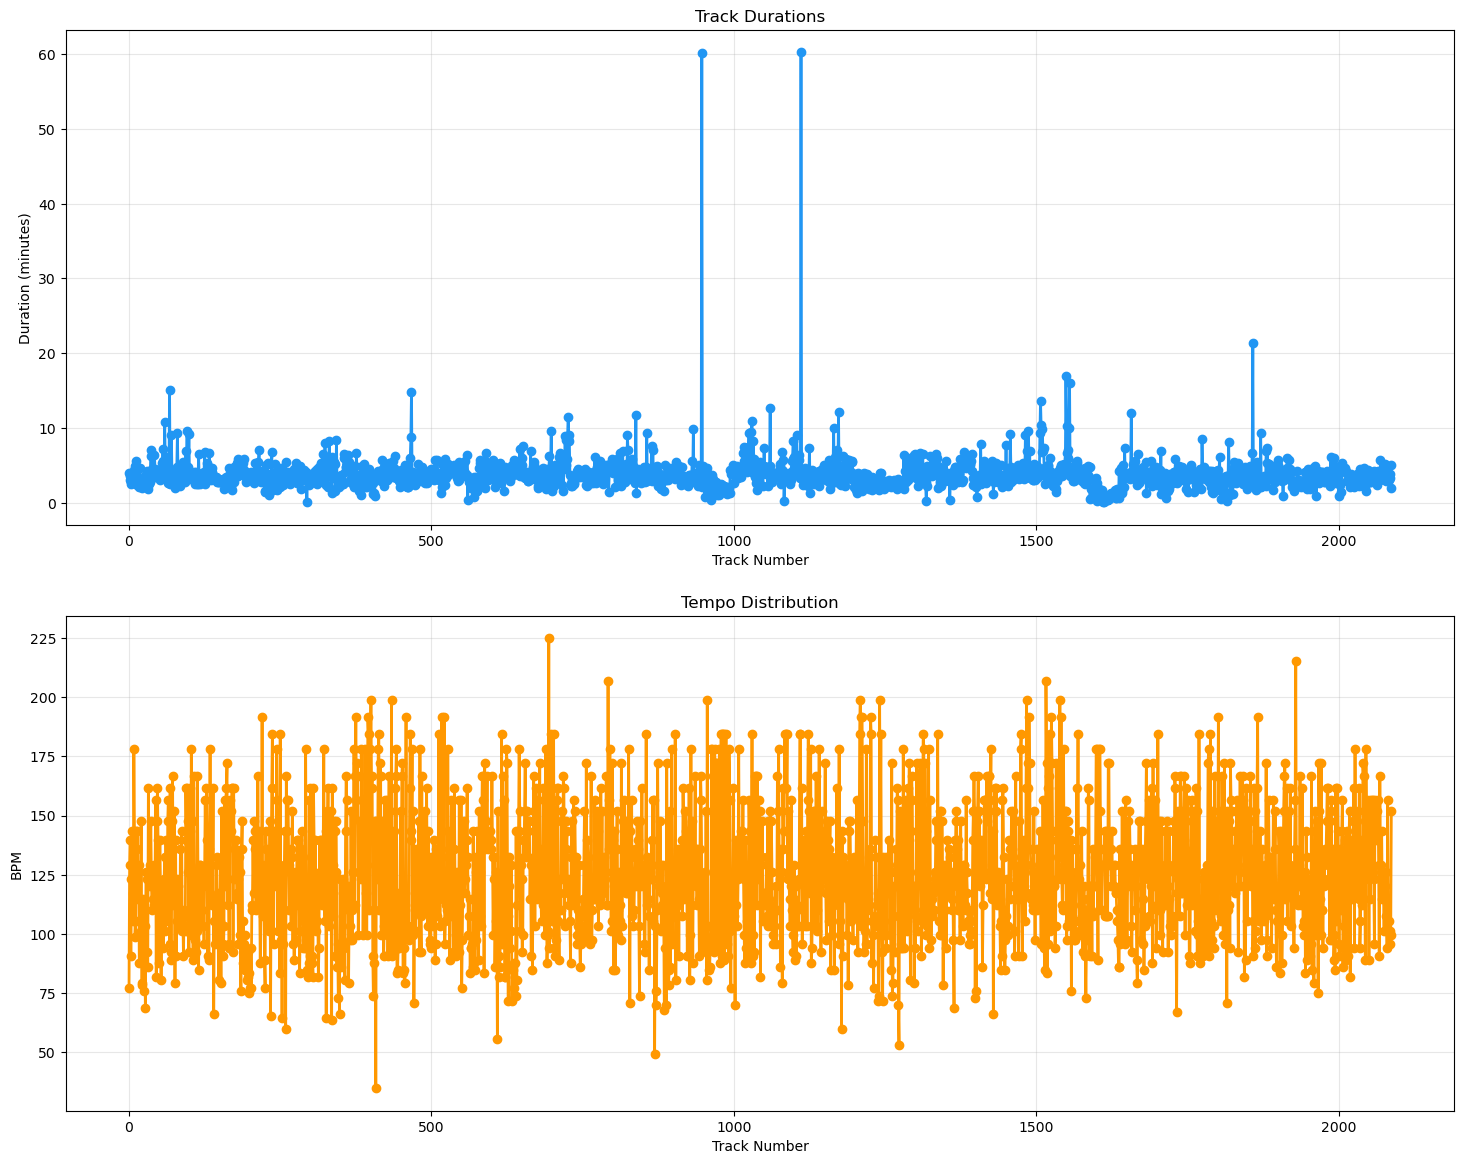

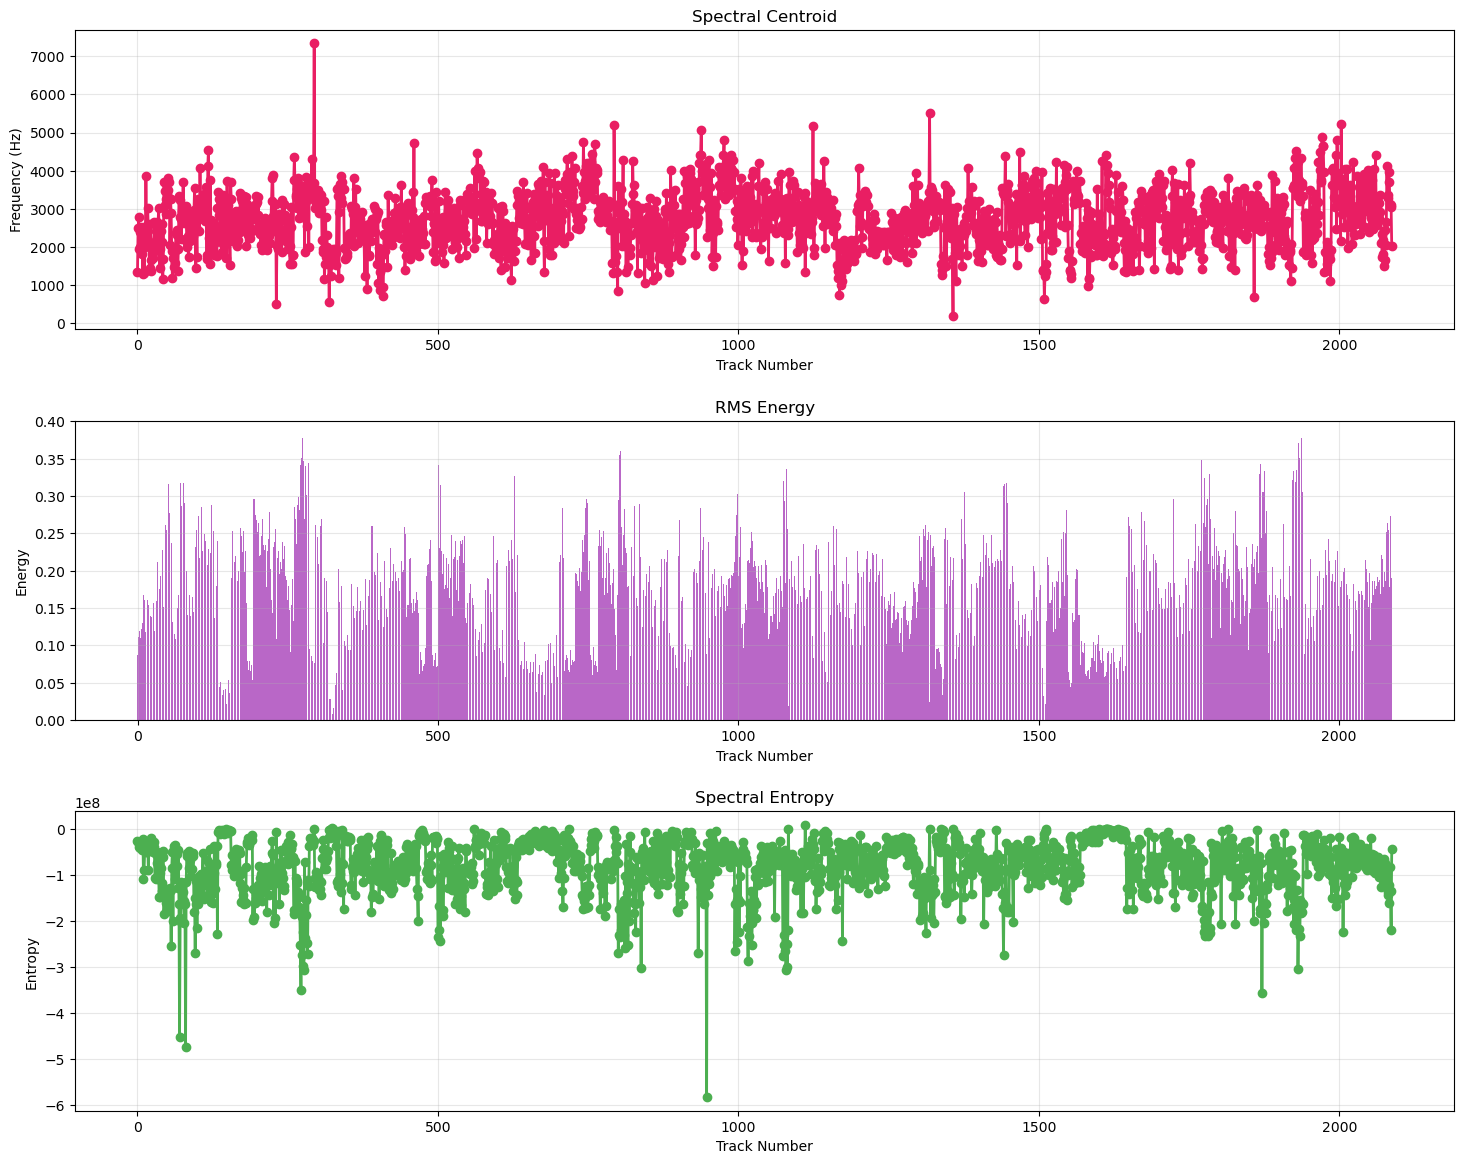

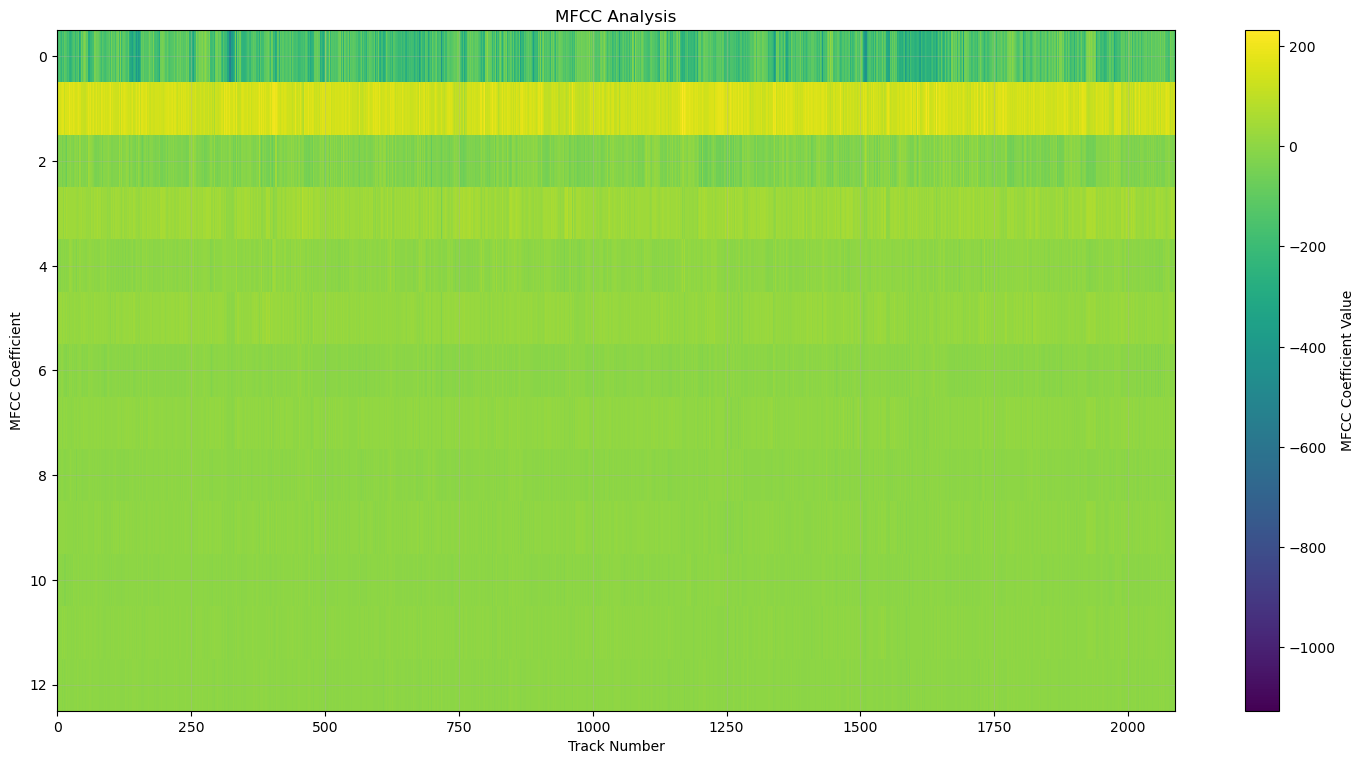

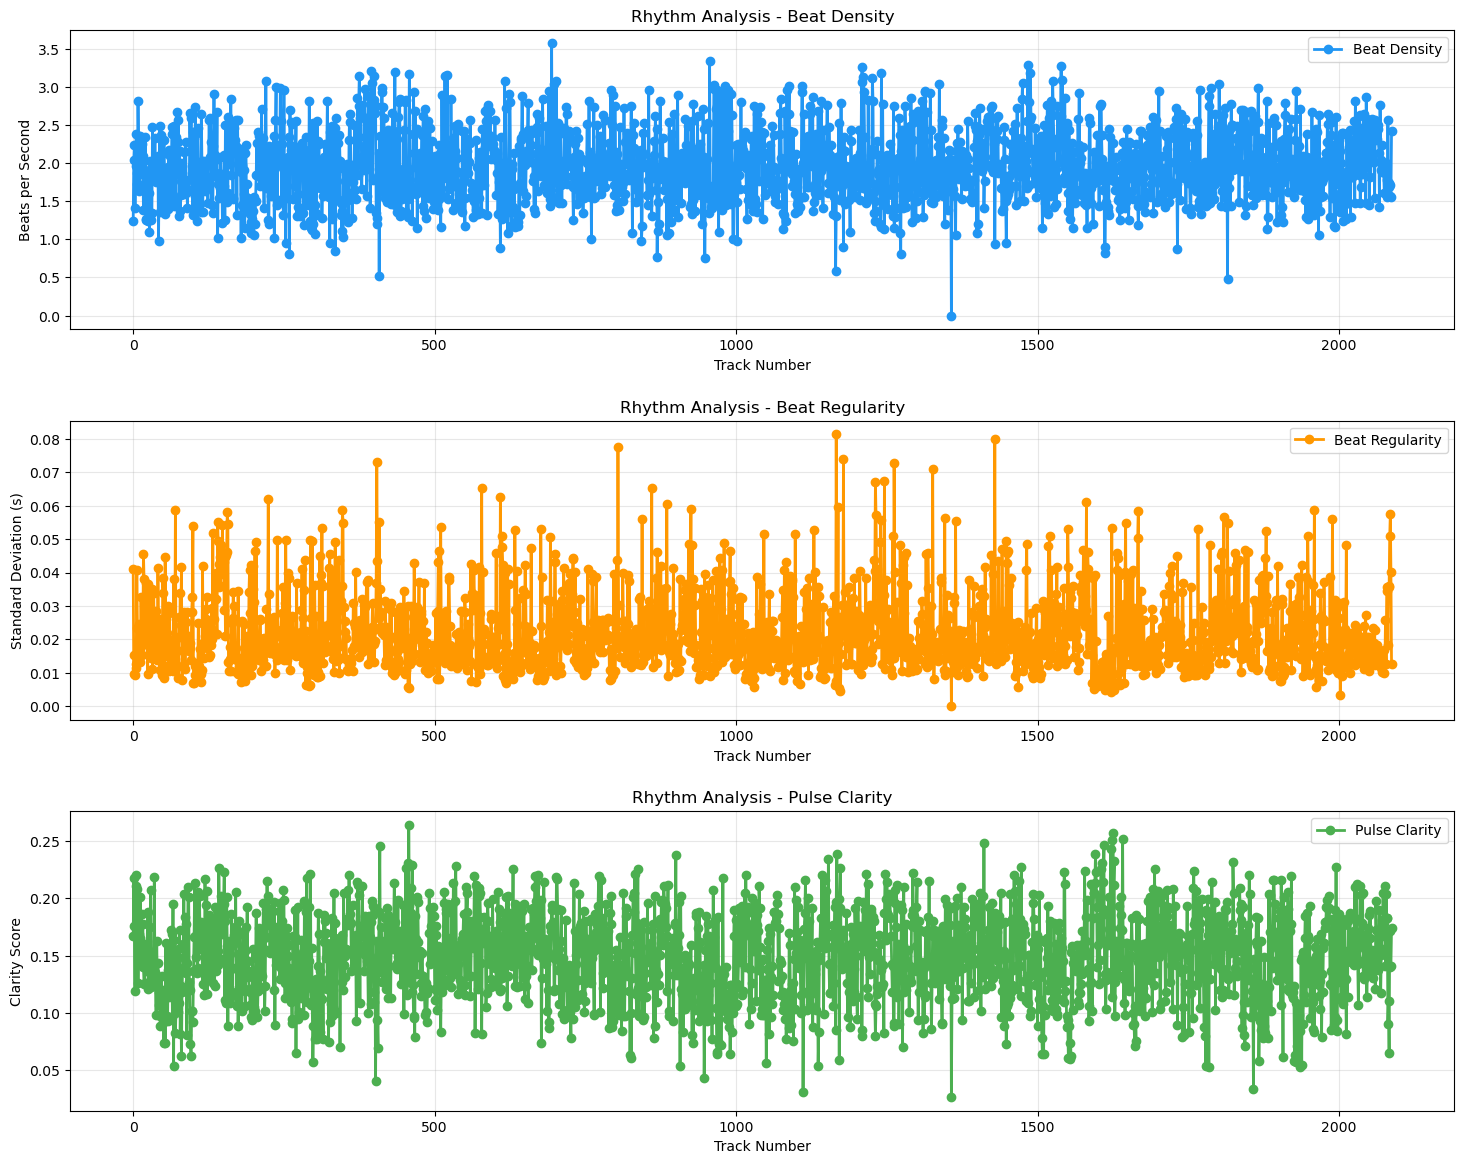

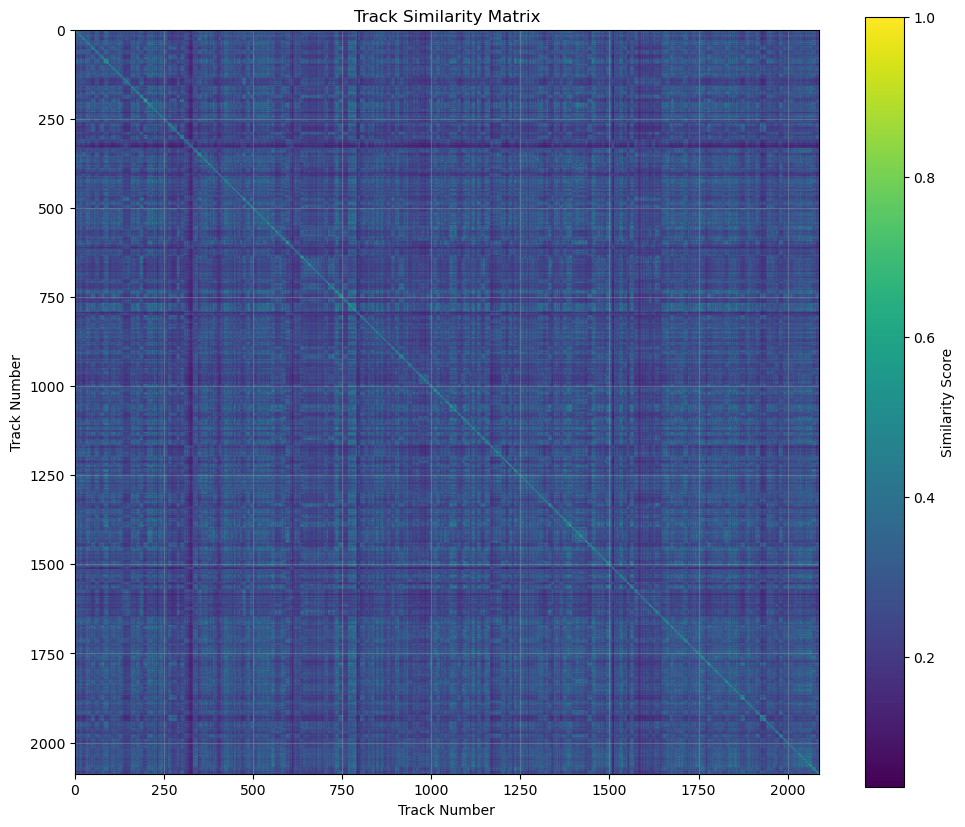

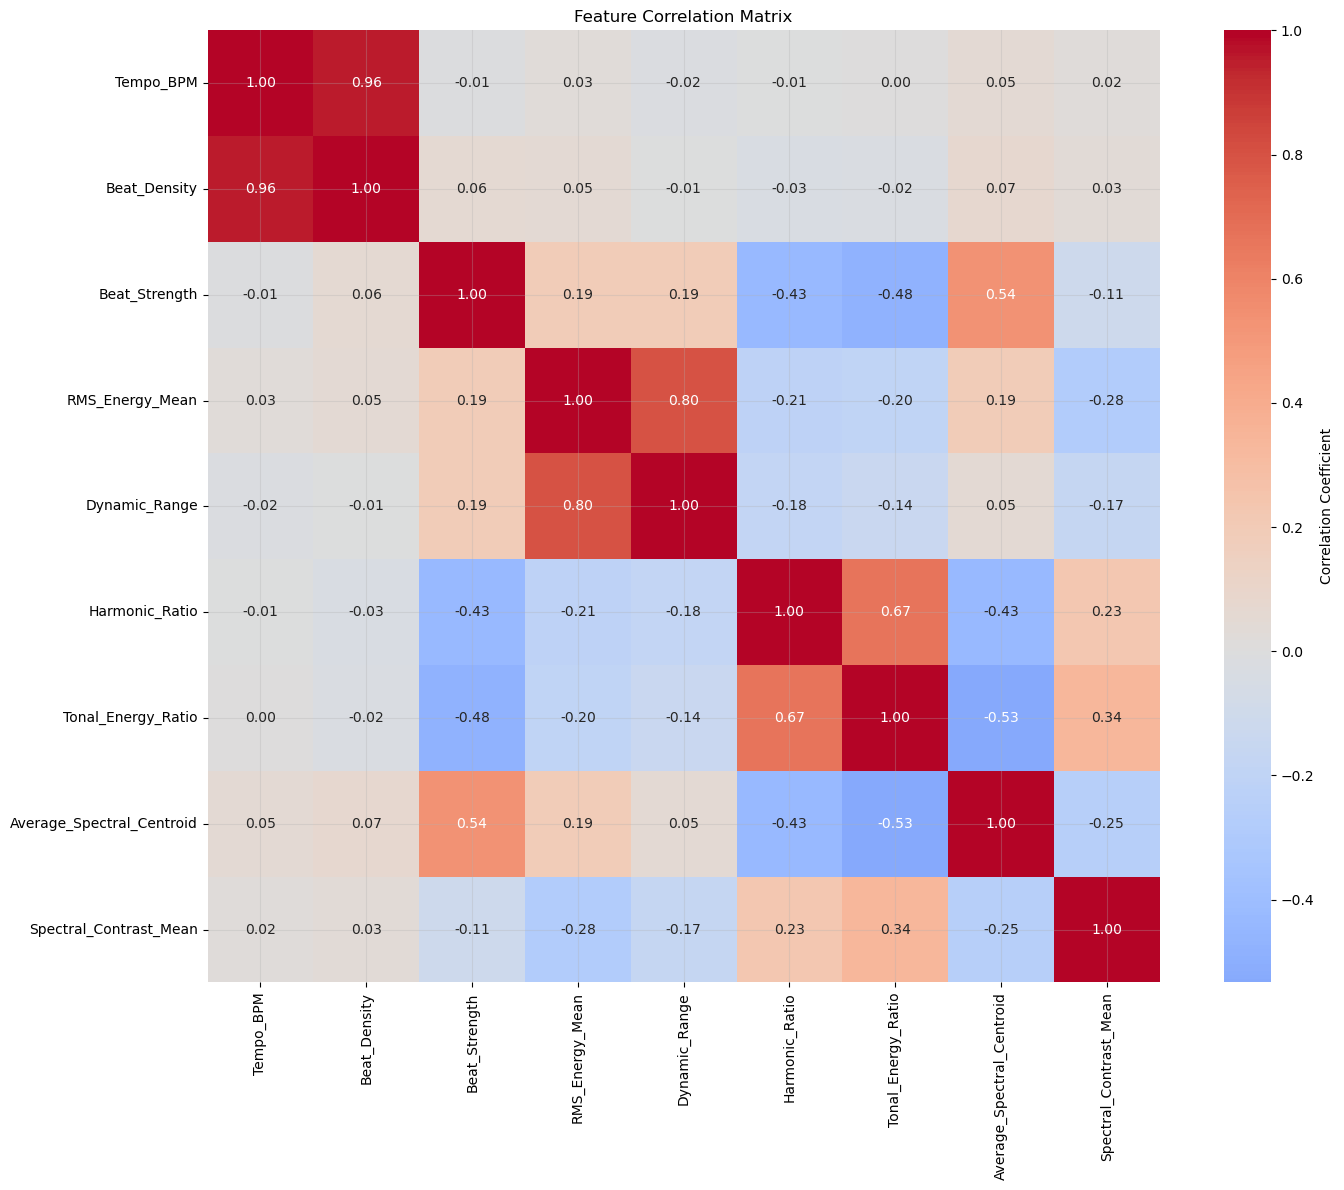

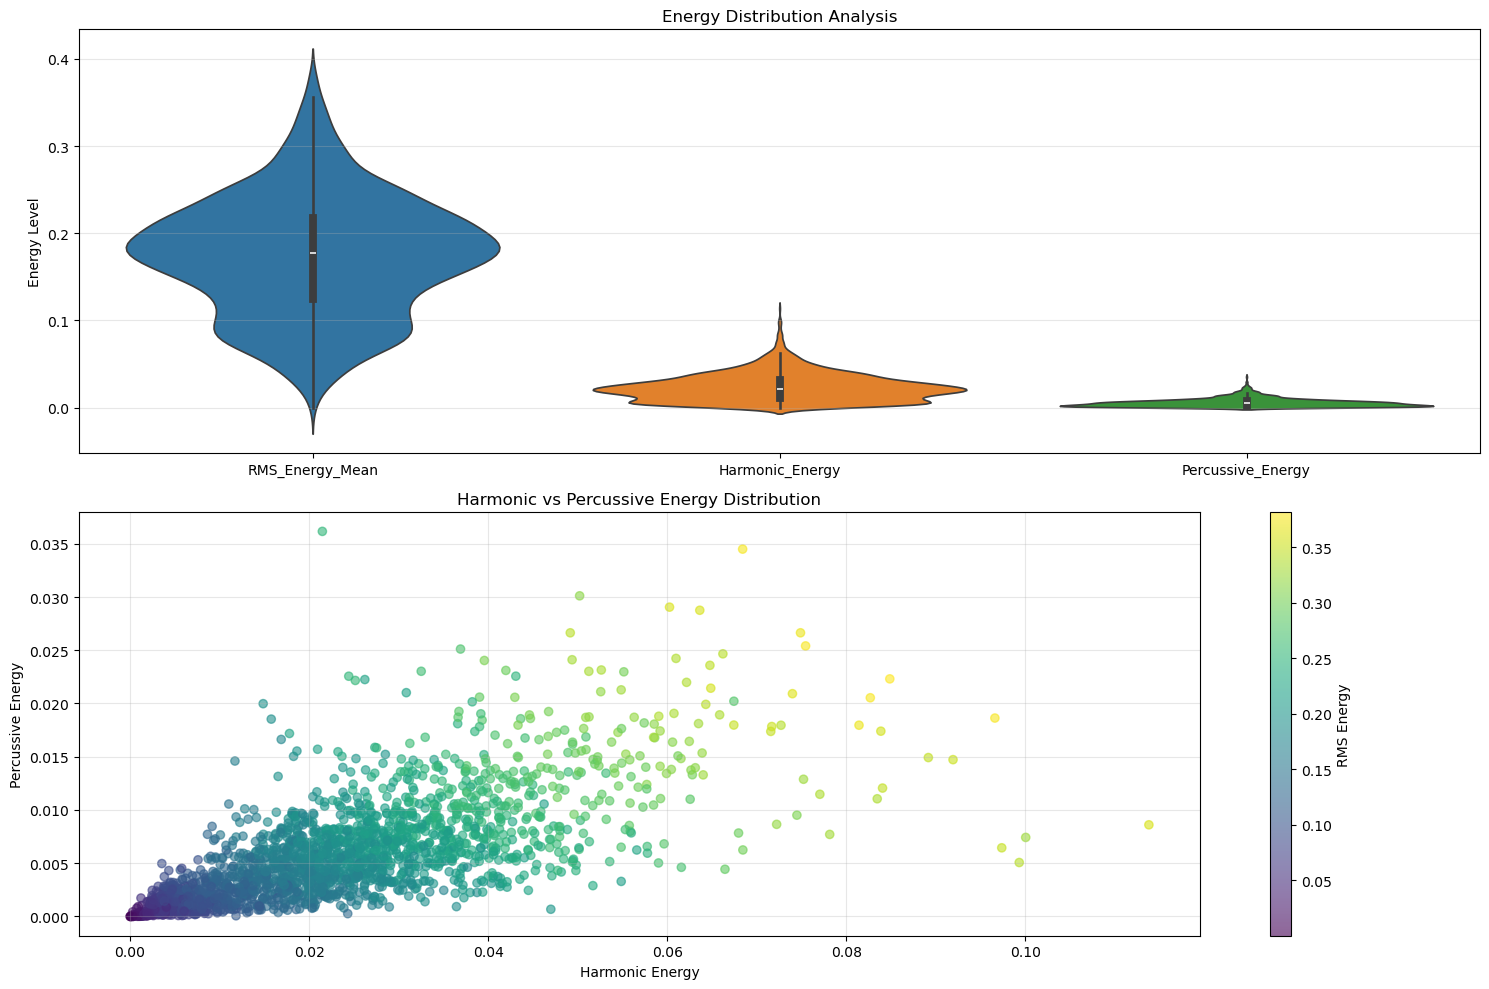

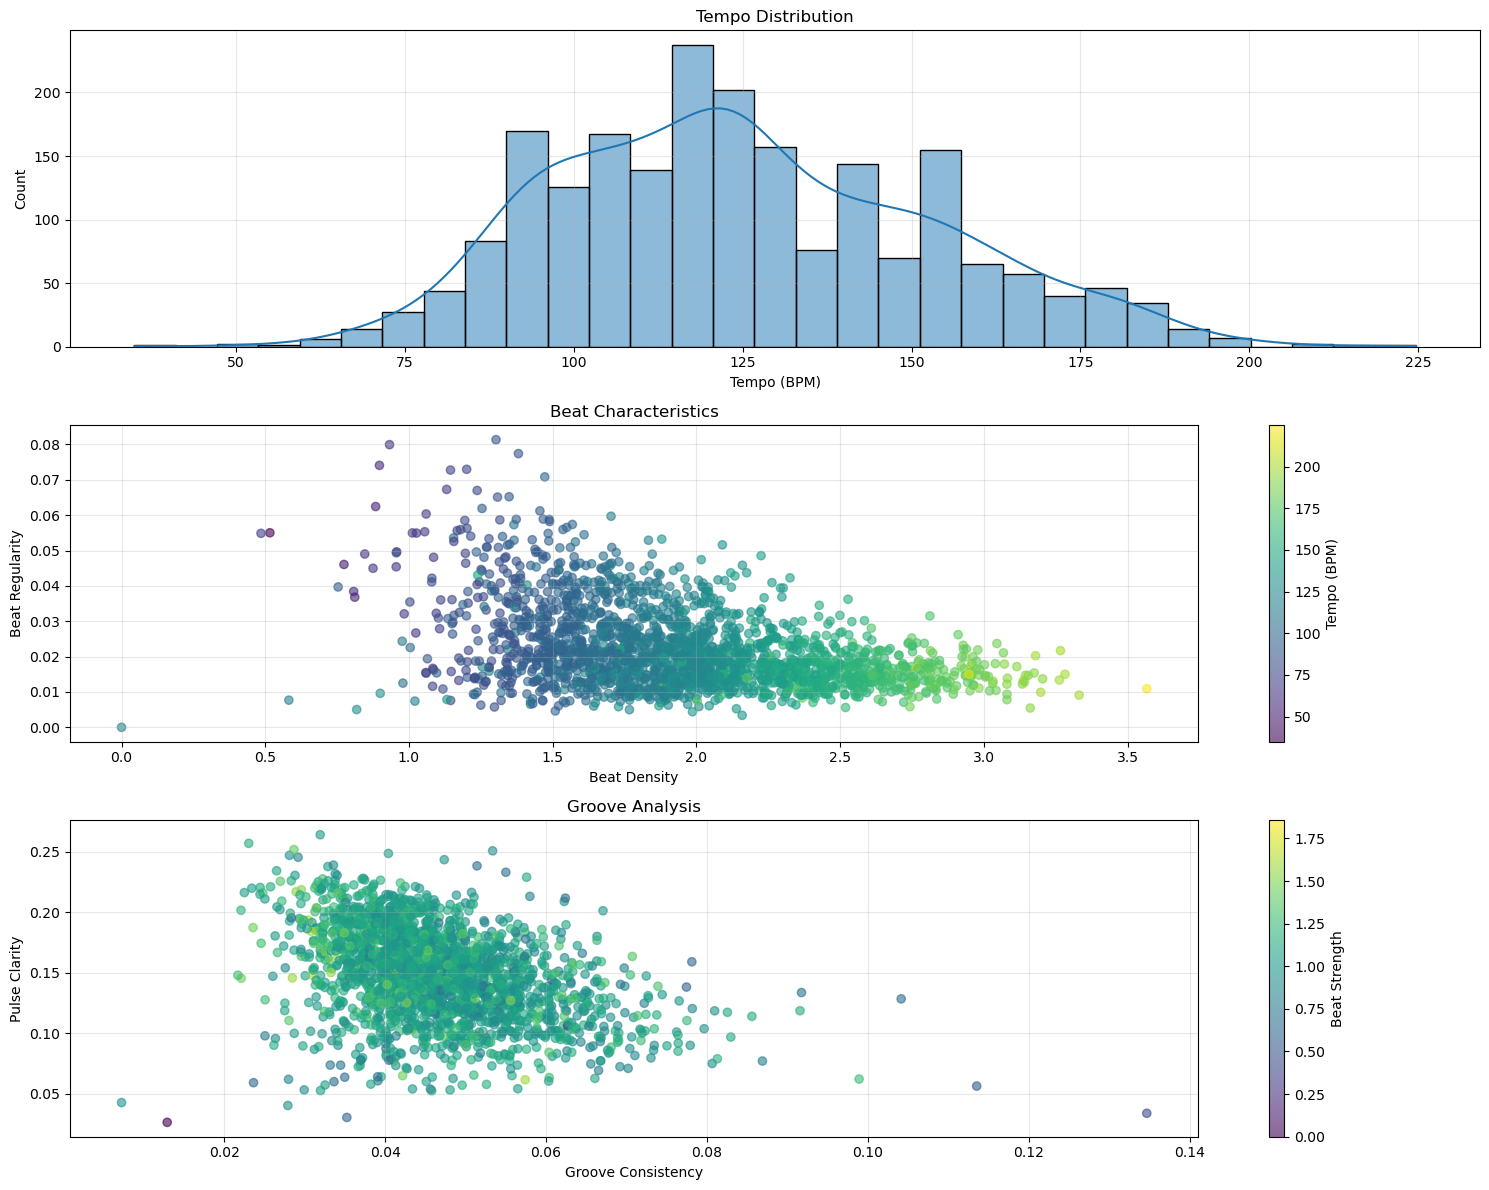

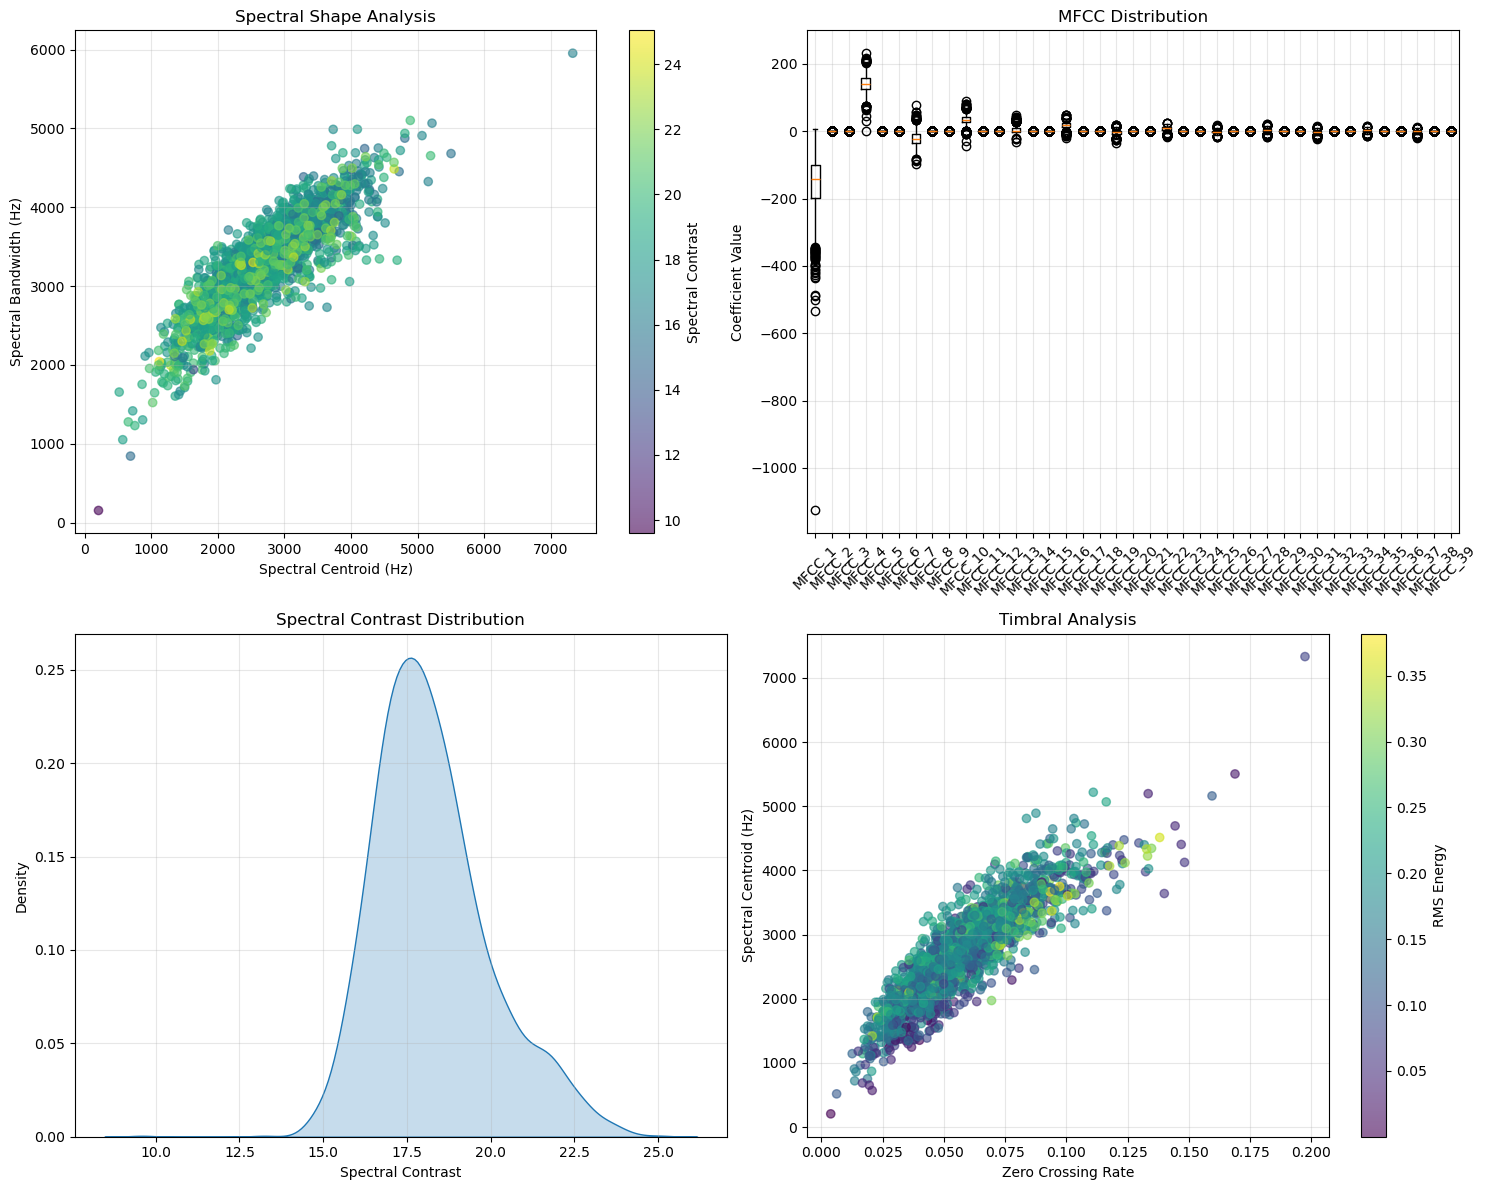

Visualizations created successfully.

Generating HTML report...
HTML report generated: analysis_report.html

Analysis Summary:

Analysis Statistics

Track Statistics:
Total Duration: 7993.61 minutes
Average BPM: 124.8
BPM Range: 34.9 - 224.7

Key Distribution:
C: 870 tracks
A: 182 tracks
E: 178 tracks
G: 167 tracks
D: 162 tracks
G#: 135 tracks
F: 133 tracks
F#: 62 tracks
D#: 58 tracks
B: 54 tracks
C#: 53 tracks
A#: 34 tracks

Energy Analysis:
Average RMS Energy: 0.174
Dynamic Range: 0.411

Extended statistics available! Enter 'y' to view detailed analysis.



Show extended statistics? (y/n):  y



=== Extended Analysis Statistics ===

Key Analysis:
Most common key: C (870 tracks)
Average key confidence: 18.18

Pitch Statistics:
Average pitch: 1331.53 Hz
Pitch range: 3852.29 Hz
Pitch stability: 962.43

Rhythm Analysis:
Average tempo: 124.8 BPM
Tempo range: 34.9 - 224.7 BPM
Average beat density: 1.96 beats/sec
Beat regularity: 0.022

Dynamic Range Analysis:
Average dynamic range: 0.411
Peak energy: 0.411
Valley energy: 0.000

Harmonic Content:
Average harmonic ratio: 6.08
Tonal energy ratio: 0.59

Spectral Characteristics:
Average spectral centroid: 2732.38 Hz
Spectral contrast: 18.26

All outputs saved to: Music\Analysis\fulllibanalysis_20241113_000324

Analysis process completed.


In [28]:
# Cell 10 - Execution Entry Point
if __name__ == "__main__":
    run_analysis()